In [42]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

SCOPETYPE = 'OPENADC'
SS_VER='SS_VER_1_1'

In [43]:
# scope.dis()
# target.dis()

In [44]:
import chipwhisperer as cw

try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()



In [45]:
try:
    target = cw.target(scope)
except IOError:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope)

print("INFO: Found ChipWhisperer😍")

INFO: Found ChipWhisperer😍


In [63]:
scope.default_setup()
scope.gain.db = 50
scope.adc.samples = 16000
scope.clock.clkgen_freq = 4e6
scope.clock.adc_src = "clkgen_x4"
scope.io.tio1 = 'serial_tx'
scope.io.tio2 = 'serial_rx'

In [64]:
def capture_trace(_ignored=None):
    ktp = cw.ktp.Basic()
    key, text = ktp.next()
    return cw.capture_trace(scope, target, text).wave

In [65]:
wave = capture_trace()
print("✔️ OK to continue!")

✔️ OK to continue!


In [66]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []
textout_array = []

key, text = ktp.next()

target.set_key(key)

N = 2500
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        
        continue
    
    response = target.simpleserial_read('r', 16)
    textout_array.append(response)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

/tmp/ipykernel_7629/1687964465.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/2500 [00:00<?, ?it/s]

In [67]:
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)
# ###################

<IPython.core.display.Javascript object>


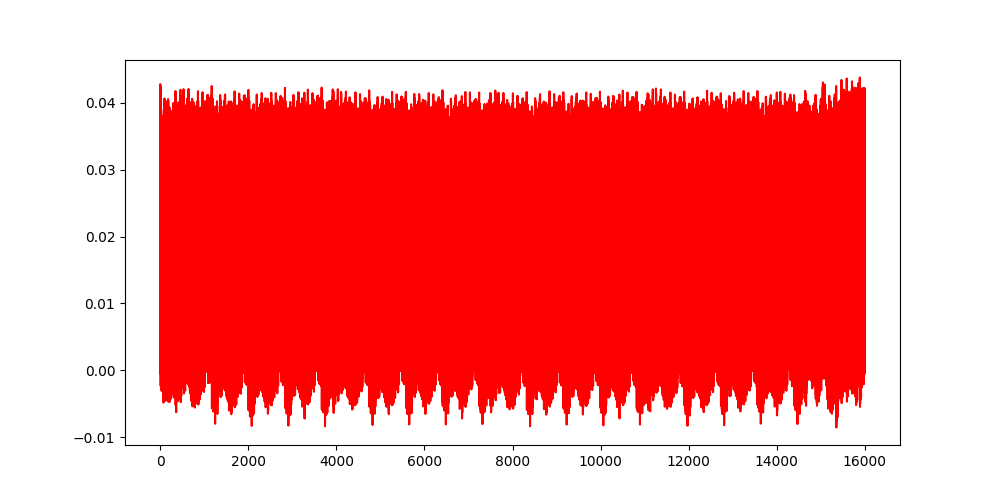

In [75]:
%matplotlib notebook
import matplotlib.pylab as plt

t_bar = mean(trace_array) 
o_t = std_dev(trace_array, t_bar)

plt.rcParams["figure.figsize"] = (10,5)
plt.figure()
plt.plot(t_bar, 'r')
plt.show()

In [69]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

HW = [bin(n).count("1") for n in range(0, 256)]


In [70]:
assert HW[aes_internal(0xA1, 0x79)] == 3
assert HW[aes_internal(0x22, 0xB1)] == 5
print("✔️ OK to continue!")

✔️ OK to continue!


In [71]:
a = np.array([[5, 3, 4, 4, 5, 6],
             [27, 2, 3, 4, 12, 6],
              [1, 3, 5, 4, 5, 6],
              [1, 2, 3, 4, 5, 6],
             ]).transpose()
a_bar = mean(a)
b = np.array([[5, 4, 3, 2, 1, 3]]).transpose()
b_bar = mean(b)

o_a = std_dev(a, a_bar)
o_b = std_dev(b, b_bar)

ab_cov = cov(a, a_bar, b, b_bar)

In [74]:
from tqdm import tnrange
maxcpa = [0] * 256

for kguess in tnrange(0, 256):
    hws = np.array([[HW[aes_internal(textin[2],kguess)] for textin in textin_array]]).transpose()
    
    hws_bar = mean(hws)
    o_hws = std_dev(hws, hws_bar)
    correlation = cov(trace_array, t_bar, hws, hws_bar)
    cpaoutput = correlation/(o_t*o_hws)
    maxcpa[kguess] = max(abs(cpaoutput))

guess = np.argmax(maxcpa)
guess_corr = max(maxcpa)

print("Key guess: ", hex(guess))
print("Correlation: ", guess_corr)

/tmp/ipykernel_7629/4230256529.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for kguess in tnrange(0, 256):


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  0x15
Correlation:  0.19293890925917193


<IPython.core.display.Javascript object>


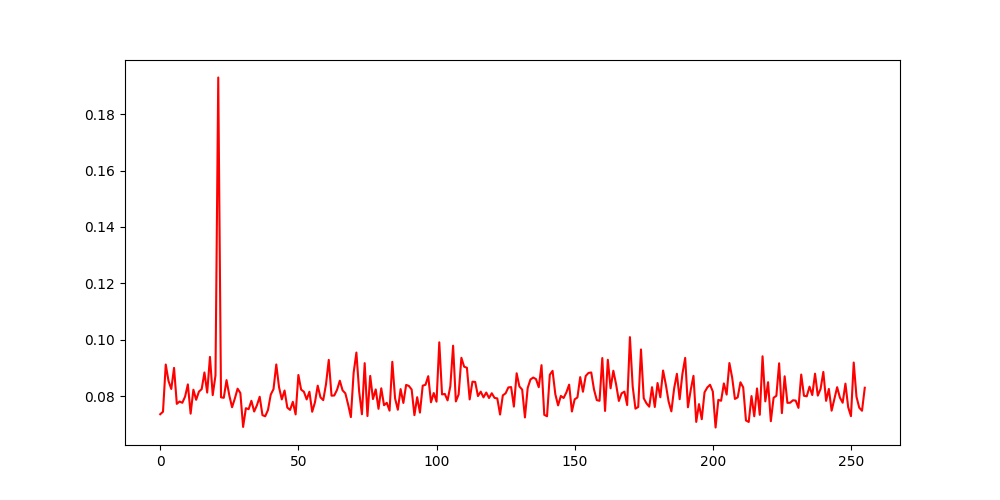

In [76]:
%matplotlib notebook
import matplotlib.pylab as plt

%matplotlib notebook
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (10,5)
plt.figure()
plt.plot(maxcpa, 'r')

plt.show()

In [79]:
key

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')